In [1]:
import numpy as np
import scipy.stats as stats
import scipy.special as special
import pandas as pd
import chaospy as cp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import pair_plot as pplt

sns.set_style("ticks")#'whitegrid')#
#sns.set_context("talk")
sns.set_style({'axes.linewidth':0.5,
               'xtick.direction': u'in',
               'xtick.major.size': 1.,
               'xtick.minor.size': 0.5,
               'ytick.direction': u'in',               
               'ytick.major.size': 1.,
               'ytick.minor.size': 0.5})  


:0: FutureWarning: IPython widgets are experimental and may change in the future.


# 0) Multivariate Normal

Model: Power Law

In [81]:
def u_m(z, z_ref, u_ref, shear):    
    if  (u_ref>1.):
        return u_ref*( (z/z_ref)**shear ) 
    else:
        return u_ref*np.ones_like(z)

z = np.arange(10,200)#np.linspace(10,200,190,endpoint=True)

with uncertain inputs: 
- u_ref
- shear

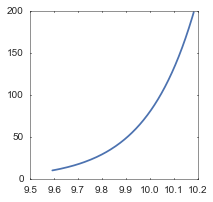

In [82]:
u_ref = 10.
z_ref = 80.
shear=0.02

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(u_m(z,z_ref,u_ref,shear),z)

In [83]:
dist_WS = cp.Weibull(shape=2., scale=10.)
dist_shear = cp.Normal(mu=0.088*(cp.log(dist_WS) - 1.), sigma=1./dist_WS)

dist_X = cp.J(dist_WS,dist_shear)
# Uncorrelated Standard Uniforms
dist_W = cp.Iid(cp.Uniform(),2)

### a) Full MC with Halton sampling

In [84]:
N = int(1e5)
sample_inputs = dist_X.sample(size=N,rule='H')
sample_u = np.array([u_m(z,z_ref,*node) for node in sample_inputs.T])

E_u = np.mean(sample_u,axis=0)
Std_u = np.std(sample_u,axis=0)
Q05_u = np.percentile(sample_u,5,axis=0)
Q95_u = np.percentile(sample_u,95,axis=0)

In [121]:
ind_120 = np.where((119<z)&(z<121))[0]
print(ind_120)

print np.where(z==160)

[110]
(array([150]),)


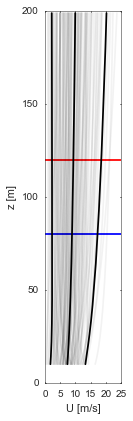

In [140]:
fig = plt.figure(figsize=[2,6])
ax = fig.add_subplot(111)
for i in range(100):
    ax.plot(sample_u[i,:],z,'k',alpha=0.05)
ax.plot(E_u,z,'k')
ax.plot(Q05_u,z,'k')
ax.plot(Q95_u,z,'k')

ax.hlines(120,xmin=0, xmax=25,color='r')
ax.hlines(80,xmin=0, xmax=25,color='b')

ax.set_xlabel('U [m/s]')
ax.set_ylabel('z [m]')

fig.tight_layout()
fig.savefig('Figures/0_Shear_ABL_example_MC_ABL.pdf')
print

In [125]:
df_MC = pd.DataFrame(columns=['u_80','shear','u_120','u_160'],
                     data=(np.vstack([sample_inputs,sample_u[:,110],sample_u[:,150]])).T)

In [133]:
var_list = ['u_80','shear','u_120'] #,'u_160'
var_labels = {'u_80':'u_80 [m/s]','shear':r'$\alpha$ [-]','u_120':'u_120 [m/s]','u_160':'u_160 [m/s]'}
var_lims = {'u_80':[0,40],'shear':[-1.,1.0],'u_120':[0,40],'u_160':[0,40]}

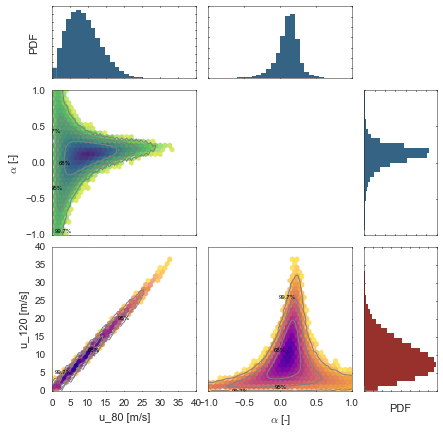

In [134]:
fig,ax= pplt.pair_plot(df_MC, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       num_inputs=2, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[6,6])
fig.savefig('Figures/0_Shear_ABL_example_MC.png',dpi=400)

In [142]:
stats.weibull_min.fit(df_MC.u_120.values,floc=0.)

(1.928811893426484, 0.0, 10.488393589430949)

# Mean shear ABL

In [145]:
print z[110]
u_m(z[110],z_ref,10.,df_MC.shear.mean())

120


10.369788434880654

### b) PCE with Point collocation: Least squares

In [102]:
D = 4     # Number of dimensions
M = 6     # Order of the polynomial
N = M + 1 # Number of terms

In [109]:
P = cp.orth_ttr(M,dist_W)
nodes_X = dist_X.sample(3*special.comb(D+M,M),rule='H') 
nodes_W = dist_X.fwd(nodes_X)

nodes_u = np.array([u_m(z,z_ref,*node) for node in nodes_X.T])

print len(P)

u_hat = cp.fit_regression(P, nodes_W, nodes_u)#, rule='LL', n_nonzero_coefs=20, eps=1e-3)

28


In [110]:
df_train = pd.DataFrame(columns=['u_80','shear','u_120'],
                        data=(np.vstack([nodes_X,nodes_u[:,120]])).T)

In [111]:
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in dist_X.fwd(sample_inputs).T ])
#sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_inputs.T ])

In [112]:
df_PCE_MC = pd.DataFrame(columns=['u_80','shear','u_120'],
                         data=(np.vstack([scales*sample_inputs,sample_u_hat[:,120]])).T)

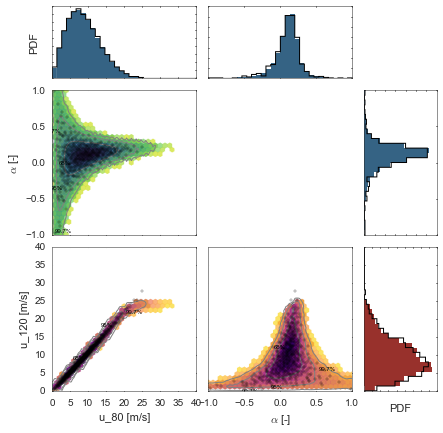

In [113]:
fig,ax= pplt.pair_plot(df_PCE_MC, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       num_inputs=2, bins=30, #alpha=0.7, 
                       colors=None, opt='hexbin', figsize=[6, 6])
fig,ax= pplt.pair_plot(df_train, var_list=var_list, var_lims=var_lims, var_labels=var_labels, 
                       marker='+',num_inputs=2, bins=30, alpha=0.8, 
                       colors='black', opt='scatter', fig=fig,ax=ax, figsize=[6, 6])
fig.savefig('Figures/0_Shear_ABL_example_train.png',dpi=400)

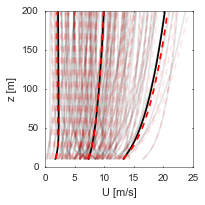

In [114]:
E_u_hat = np.mean(sample_u_hat,axis=0)
Std_u_hat = np.std(sample_u_hat,axis=0)
Q05_u_hat = np.percentile(sample_u_hat,5,axis=0)
Q95_u_hat = np.percentile(sample_u_hat,95,axis=0)

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
for i in range(100):
    ax.plot(sample_u[i,:],z,'k',alpha=0.1)
ax.plot(E_u,z,'k')
ax.plot(Q05_u,z,'k')
ax.plot(Q95_u,z,'k')

for i in range(100):
    ax.plot(sample_u_hat[i,:],z,'--r',alpha=0.1)
ax.plot(E_u_hat,z,'--r')
ax.plot(Q05_u_hat,z,'--r')
ax.plot(Q95_u_hat,z,'--r')

ax.set_xlabel('U [m/s]')
ax.set_ylabel('z [m]')

fig.tight_layout()
fig.savefig('Figures/0_Shear_ABL_example_MC_PCE_ABL.pdf')
print

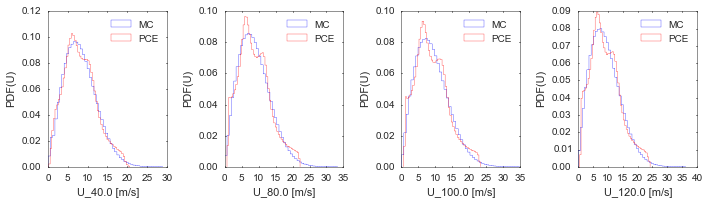

In [115]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([40., 80., 100., 120.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(z==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
            )

    ax.hist(sample_u_hat[:,np.where(z==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
            )

    ax.set_ylabel('PDF(U)')
    ax.set_xlabel('U_'+str(x_ref)+' [m/s]')
    ax.legend(loc='upper right')

fig.tight_layout()
fig.savefig('Figures/0_Shear_ABL_example_bot.pdf')
print

In [90]:
Sensitivity.shape

(4, 190)

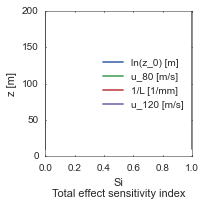

In [92]:
Sensitivity = cp.Sens_t(u_hat, dist_W)

fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
for i in range(len(var_labels)-1):
    ax.plot(Sensitivity[i,:],z,label=var_labels.values()[i])

ax.legend(loc='center right')

ax.set_ylabel('z [m]')
ax.set_xlabel('Si\nTotal effect sensitivity index')

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_Sens.pdf')


### c) PCE with Semi-spectral projection

16


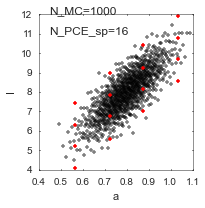

In [16]:
M = 3
P = cp.orth_ttr(M,dist_R)
nodes_R, weights_R = cp.generate_quadrature(M, dist_R, rule='G')
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) 
#weights_Q = weights_R*dist_Q.pdf(nodes_Q)/dist_R.pdf(nodes_R)

sample_u_train = [u(x,*node) for node in nodes_Q.T]
u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_train)


fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.plot(sample_inputs[0,:],sample_inputs[1,:],'.k',alpha=0.5)
ax.plot(nodes_Q[0,:],nodes_Q[1,:],'.r')
ax.set_xlabel('a')
ax.set_ylabel('I')

ax.text(0.45,12,'N_MC='+str(len(sample_inputs[0,:])))
ax.text(0.45,11,'N_PCE_sp='+str(len(nodes_Q[0,:])))

fig.tight_layout()
fig.savefig('Figures/3_MultiNormal_MC_sample_sp.pdf')
print len(weights_R)

In [17]:
mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
# Repeat the MC sample ussing the surrogate model
sample_tr_inputs = dist_R.sample(size=1000,rule='H')
sample_u_hat = np.array([u_hat(*in_vars) for in_vars in sample_tr_inputs.T ])

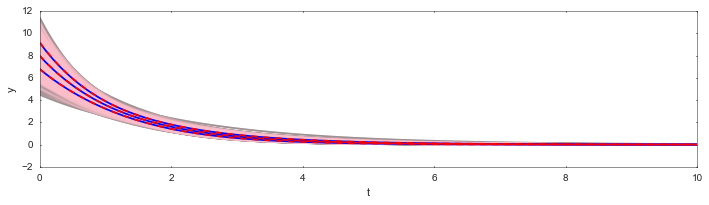

In [18]:
fig = plt.figure(figsize=[10,3])
ax = fig.add_subplot(111)

ax.plot(x,sample_u.T,'grey')
ax.plot(x,sample_u_hat.T,'pink',alpha=0.25)

ax.plot(x,E_u,'blue')
ax.plot(x,E_u+Std_u,'blue')
ax.plot(x,E_u-Std_u,'blue')

ax.plot(x,mean_u_pc,'--r')
ax.plot(x,mean_u_pc+std_u_pc,'--r')
ax.plot(x,mean_u_pc-std_u_pc,'--r')

ax.set_xlabel('t')
ax.set_ylabel('y')

fig.tight_layout()

print

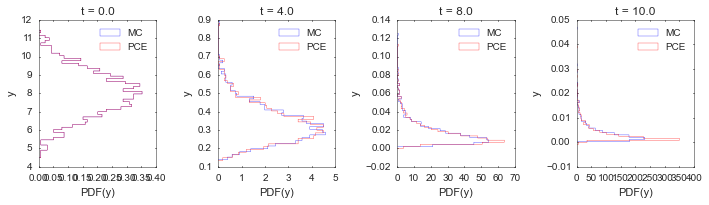

In [19]:
fig = plt.figure(figsize=[10,3])

for i,x_ref in enumerate([0., 4., 8., 10.]):
    ax = fig.add_subplot(1,4,i+1)
    ax.hist(sample_u[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='blue',
             normed=True,
             cumulative=False,
             label='MC',
             orientation=u'horizontal',
            )

    ax.hist(sample_u_hat[:,np.where(x==x_ref)[0]],
             bins=50,#np.linspace(-0.2,.2,50),
             histtype='step',
             color='red',
             normed=True,
             cumulative=False,
             label='PCE',
             orientation=u'horizontal',
            )

    ax.set_ylabel('y')
    ax.set_xlabel('PDF(y)')
    ax.set_title('t = '+str(x_ref))
    ax.legend(loc='upper right')
    fig.tight_layout()
print

### d) Conclusion

PCE with spectral collocation converges faster because of the efficient quadrature rules. Use Gaussian quardature rule for the fastest convergences. 

PCE with point collocation and a simple least square polynomial fit is less efficient but robust. 

### e) Convergence

```python
sample_inputs_ref = dist_Q.sample(size=10**6,rule='M')
sample_u_ref = np.array([u(x,*node) for node in sample_inputs_ref.T])

E_u_ref = np.mean(sample_u_ref,axis=0)
Std_u_ref = np.std(sample_u_ref,axis=0)
#```

In [20]:
#```python
D = 2    # Number of dimensions
M = 15    # Order of the polynomial

P = cp.orth_ttr(M,dist_R)
nodes_R, weights_R = cp.generate_quadrature(M, dist_R, rule='G')
nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) 
#weights_Q = weights_R*dist_Q.pdf(nodes_Q)/dist_R.pdf(nodes_R)

sample_u_train = [u(x,*node) for node in nodes_Q.T]
u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_train)

E_u_ref, Std_u_ref = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
#```

In [21]:
def PCE(M):
    # M: Order of the polynomial
    D = 2    # Number of dimensions
    
    P = cp.orth_ttr(M,dist_R)
    # Hammersley sampling proved to be optimally stable [Hosder]=ref(at)Chaospy[31]
    Npc = 3*special.comb(D+M-1,M-1) 
    nodes_R = dist_R.sample(Npc,rule='M') 
    nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R))
    sample_u_pc = np.array([u(x,*node) for node in nodes_Q.T])

    print Npc #len(P)

    u_hat = cp.fit_regression(P, nodes_R, sample_u_pc)
    
    mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
    
    
    Error_E = np.trapz(np.abs(E_u_ref - mean_u_pc)/E_u,x)/10.
    Error_Std = np.trapz(np.abs(std_u_pc**2./Std_u_ref**2. - 1.),x)/10.  
    
    return Npc,Error_E, Error_Std

In [22]:
order   = range(2,12)
Npc     = np.zeros(len(order))
Error_E = np.zeros(len(order))
Error_Std = np.zeros(len(order))

for i,M in enumerate(order):
    Npc[i],Error_E[i], Error_Std[i] = PCE(M)

9.0
18.0
30.0
45.0
63.0
84.0
108.0
135.0
165.0
198.0


In [23]:
def PCE_sp(M):
    # M: Order of the polynomial
    D = 2    # Number of dimensions
    
    P = cp.orth_ttr(M,dist_R)
    nodes_R, weights_R = cp.generate_quadrature(M, dist_R, rule='G')
    nodes_Q = dist_Q.inv(dist_R.fwd(nodes_R)) 

    sample_u_train = [u(x,*node) for node in nodes_Q.T]
    u_hat = cp.fit_quadrature(P, nodes_R, weights_R, sample_u_train)
    Npc = len(nodes_R[0,:])
    print Npc #len(P)
    
    mean_u_pc, std_u_pc = cp.E(u_hat, dist_R), cp.Std(u_hat, dist_R)
    
    
    Error_E = np.trapz(np.abs(E_u_ref - mean_u_pc)/E_u,x)/10.
    Error_Std = np.trapz(np.abs(std_u_pc**2./Std_u_ref**2. - 1.),x)/10.  
    
    return Npc,Error_E, Error_Std

In [24]:
order   = range(2,10)
Npc_sp     = np.zeros(len(order))
Error_E_sp = np.zeros(len(order))
Error_Std_sp = np.zeros(len(order))

for i,M in enumerate(order):
    Npc_sp[i],Error_E_sp[i], Error_Std_sp[i] = PCE_sp(M)

9
16
25
36
49
64
81
100


In [25]:
def MC(Nmc):
    sample_inputs = dist_Q.sample(size=Nmc,rule='H')
    sample_u = np.array([u(x,*node) for node in sample_inputs.T])

    E_u_mc = np.mean(sample_u,axis=0)
    Std_u_mc = np.std(sample_u,axis=0)
    
    Error_E_mc = np.trapz(np.abs(E_u_ref - E_u_mc)/E_u,x)/10.
    Error_Std_mc = np.trapz(np.abs(Std_u_mc**2./Std_u_ref**2.-1.),x)/10.
    
    return Error_E_mc, Error_Std_mc

In [26]:
Nmc     = [10,10**2,10**3,10**4,10**5]
Error_E_mc = np.zeros(len(Nmc))
Error_Std_mc = np.zeros(len(Nmc))

for i,N in enumerate(Nmc):
    Error_E_mc[i], Error_Std_mc[i] = MC(N)

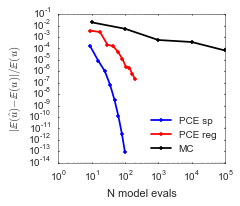

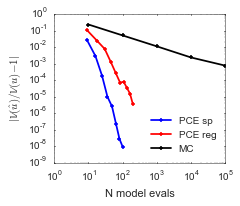

In [27]:
output_name_label = 'u'

fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-6,1e0])
ax.plot(Npc_sp,Error_E_sp,'.-b',label='PCE sp')
ax.plot(Npc,Error_E,'.-r',label='PCE reg')
ax.plot(Nmc,Error_E_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{E}(\hat{'+output_name_label+'})-\mathbb{E}('+output_name_label+')|/\mathbb{E}('+output_name_label+')$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/3_Convergence_E_'+output_name_label+'.pdf')


fig = plt.figure(figsize=[3.5,3])
ax = fig.add_subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([1e-4,1e0])
ax.plot(Npc_sp,Error_Std_sp,'.-b',label='PCE sp')
ax.plot(Npc,Error_Std,'.-r',label='PCE reg')
ax.plot(Nmc,Error_Std_mc,'.-k',label='MC')
ax.set_xlabel('N model evals')
ax.set_ylabel(r'$|\mathbb{V}(\hat{'+output_name_label+'})/\mathbb{V}('+output_name_label+') -1|$')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Figures/3_Convergence_V_'+output_name_label+'.pdf')